In [1]:
Alpha_Name = "AlphaNet_Original_Input_12.22_1d_return_normalized"
path = '/home/wuwenjun/Data/' + Alpha_Name +'/'
output_path = "/home/wuwenjun/Alpha_Factor/" + Alpha_Name + "/result/"
target = "1d_ret"

In [2]:
from os import walk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import torch.utils.data as Data
import torch.optim as optim
from tqdm import tqdm
from torch.autograd import Variable
import time
import multiprocessing as mp
from os import walk
import matplotlib.pyplot as plt
feat_num = 9

In [3]:
time_list = []
data_path = path + "Data/"
dataframe_list = pd.DataFrame()
for f, _, i in walk(data_path):
    for j in tqdm(i):
        time_list.append(j)
time_list.sort()     
time_list

100%|██████████| 26/26 [00:00<00:00, 248976.95it/s]


['2015-01-01_2015-03-01.par',
 '2015-03-01_2015-06-01.par',
 '2015-06-01_2015-09-01.par',
 '2015-09-01_2016-01-01.par',
 '2016-01-01_2016-03-01.par',
 '2016-03-01_2016-06-01.par',
 '2016-06-01_2016-09-01.par',
 '2016-09-01_2017-01-01.par',
 '2017-01-01_2017-03-01.par',
 '2017-03-01_2017-06-01.par',
 '2017-06-01_2017-09-01.par',
 '2017-09-01_2018-01-01.par',
 '2018-01-01_2018-03-01.par',
 '2018-03-01_2018-06-01.par',
 '2018-06-01_2018-09-01.par',
 '2018-09-01_2019-01-01.par',
 '2019-01-01_2019-03-01.par',
 '2019-03-01_2019-06-01.par',
 '2019-06-01_2019-09-01.par',
 '2019-09-01_2020-01-01.par',
 '2020-01-01_2020-03-01.par',
 '2020-03-01_2020-06-01.par',
 '2020-06-01_2020-09-01.par',
 '2020-09-01_2021-01-01.par',
 '2021-01-01_2021-03-01.par',
 '2021-03-01_2021-06-01.par']

In [4]:
train_timestamp = time_list[:15]
test_timestamp = time_list[17:21]
trainx , trainy , testx , testy = [] , [] , [],  []

for train in tqdm(train_timestamp):
    df = pd.read_parquet(path+ "Final/" + train).set_index(["timestamp","ticker"])
    trainx.append(df.drop("target",axis=1))
    trainy.append(df['target'])
trainx = pd.concat(trainx,axis=0)
trainy = pd.concat(trainy,axis=0)

display(trainx)
display(trainy)

for test in tqdm(test_timestamp):
    df = pd.read_parquet(path+ "Final/" + test).set_index(["timestamp","ticker"])
    testx.append(df.drop("target",axis=1))
    testy.append(df['target'])
testx = pd.concat(testx,axis=0)
testy = pd.concat(testy,axis=0)
target_list = pd.DataFrame(testy.copy())
display(testx)
display(testy)

100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


,,0,1,2,3,4,5,6,7,8,9,...,638,639,640,641,642,643,644,645,646,647
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2015-02-16 09:30:00,1,1047.509016,165.116922,249.851660,924.464829,243.390500,183.194222,926.891342,158.088300,78.887819,957.587687,...,861850.412364,0.284385,0.015374,-0.376716,1.522075,1.214418,0.876160,3.017927,2.407912,1.737222
2015-02-17 09:30:00,1,1284.106922,304.746632,233.319300,1251.132811,325.347890,190.544389,1311.161194,268.878420,78.529422,1262.525551,...,825372.445636,0.240629,-0.664319,-1.631951,1.601496,1.196133,0.839082,3.175407,2.371658,1.663689
2015-02-25 09:30:00,1,1515.538580,320.840611,242.242430,1522.025569,325.437271,214.401980,1539.154187,259.118036,99.405562,1482.690747,...,784033.056545,0.292173,-0.412251,-1.377793,1.574869,1.150095,0.797058,3.122595,2.280374,1.580369
2015-02-26 09:30:00,1,1466.712161,355.378729,244.332118,1546.573639,318.650776,222.730596,1381.349806,297.507667,108.085628,1469.916341,...,727636.666545,0.038896,-0.273104,-0.482991,1.643798,1.129884,0.739729,3.259280,2.240302,1.466684
2015-02-27 09:30:00,1,1271.480107,335.406489,121.012389,1338.104279,252.973056,186.957378,1296.812044,215.993378,108.132489,1324.356569,...,756908.456182,0.381687,-0.105721,-0.411738,1.581575,1.170118,0.769491,3.135918,2.320080,1.525691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-27 09:30:00,603999,0.082862,0.094936,0.045978,0.087497,0.106180,0.032381,0.059106,0.073644,0.026521,0.082120,...,13335.060000,0.402951,0.052835,-0.447816,1.679693,1.087516,0.578776,1.679693,1.087516,0.578776
2018-08-28 09:30:00,603999,0.080306,0.081633,0.047422,0.084952,0.090367,0.035606,0.053029,0.063456,0.020300,0.077092,...,14346.732182,0.394233,0.220298,0.031169,1.555562,1.052336,0.622685,1.555562,1.052336,0.622685
2018-08-29 09:30:00,603999,0.063020,0.089384,0.029900,0.072516,0.098020,0.023056,0.041211,0.067073,0.006922,0.064161,...,14557.659273,0.537364,0.338988,0.224904,1.387218,1.017308,0.631847,1.387218,1.017308,0.631847


timestamp            ticker
2015-02-16 09:30:00  1        -0.705088
2015-02-17 09:30:00  1         0.010739
2015-02-25 09:30:00  1        -0.496705
2015-02-26 09:30:00  1         0.329146
2015-02-27 09:30:00  1        -0.716043
                                 ...   
2018-08-27 09:30:00  603999    0.854030
2018-08-28 09:30:00  603999   -0.146074
2018-08-29 09:30:00  603999    0.368227
2018-08-30 09:30:00  603999   -0.223248
2018-08-31 09:30:00  603999    0.101299
Name: target, Length: 2633778, dtype: float64

100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


,,0,1,2,3,4,5,6,7,8,9,...,638,639,640,641,642,643,644,645,646,647
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2019-03-01 09:30:00,1,165.688207,232.711217,3427.744349,101.386689,414.416073,3148.577044,67.030924,238.534806,2979.846947,104.387562,...,649553.588545,1.185682,0.652806,0.338342,0.915835,0.614836,0.378322,2.066271,1.387166,0.853520
2019-03-04 09:30:00,1,282.725782,110.374570,3677.424628,150.224776,139.970290,3342.499200,227.333064,124.981084,3323.424589,225.178552,...,912180.105273,1.593102,0.836690,-0.271027,0.945433,0.678168,0.531269,2.133042,1.530061,1.198613
2019-03-05 09:30:00,1,726.091269,90.921493,4074.423322,596.263982,125.634253,3610.732256,586.290298,87.849491,3702.108644,661.130541,...,954142.662000,1.632524,0.999027,0.416684,1.047344,0.731811,0.555702,2.362960,1.651093,1.253753
2019-03-06 09:30:00,1,845.003840,141.888017,4462.594217,717.545360,143.303417,4173.292911,766.891640,77.504891,3927.629717,785.358190,...,948318.796727,1.477505,0.859862,0.201562,1.025515,0.734699,0.552302,2.313705,1.657611,1.246100
2019-03-07 09:30:00,1,1014.573209,140.462776,4017.203618,855.510329,131.791216,4213.567911,922.083689,43.530249,3701.058311,944.326780,...,916480.905091,1.228138,0.764364,0.380725,0.984993,0.709270,0.533764,2.222293,1.600242,1.204269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24 09:30:00,688399,4.306416,340.116329,19.692806,2.862524,228.194107,9.496738,3.298782,268.928067,12.793893,3.334154,...,15981.548182,2.172885,0.517390,-1.605171,38.119224,22.031981,11.981564,38.119224,22.031981,11.981564
2020-02-25 09:30:00,688399,4.747844,192.401724,15.460579,3.510189,120.338711,9.534880,4.024956,135.827696,11.550082,4.006912,...,17682.583455,1.402695,0.361767,-0.470760,36.020696,21.723435,13.256849,36.020696,21.723435,13.256849
2020-02-26 09:30:00,688399,30.889544,128.211058,14.824962,34.196660,86.734442,9.552993,32.479942,84.015340,10.839116,32.672308,...,16471.134545,4.821169,1.447988,-0.913693,33.382127,20.729780,12.348607,33.382127,20.729780,12.348607


timestamp            ticker
2019-03-01 09:30:00  1         0.210976
2019-03-04 09:30:00  1         0.313131
2019-03-05 09:30:00  1        -0.643310
2019-03-06 09:30:00  1        -0.500139
2019-03-07 09:30:00  1        -1.180464
                                 ...   
2020-02-24 09:30:00  688399    1.771073
2020-02-25 09:30:00  688399    1.498794
2020-02-26 09:30:00  688399   -1.733627
2020-02-27 09:30:00  688399    0.522789
2020-02-28 09:30:00  688399    2.288270
Name: target, Length: 885426, dtype: float64

In [5]:
trainx = torch.from_numpy(np.array(trainx))
trainy = torch.from_numpy(np.array(trainy).reshape(-1,1))
testx = torch.from_numpy(np.array(testx))
testy = torch.from_numpy(np.array(testy).reshape(-1,1))
print("trainx.shape: " , trainx.shape)
print("trainy.shape: " , trainy.shape)
print("testx.shape: " , testx.shape)
print("testy.shape: " , testy.shape)

trainx.shape:  torch.Size([2633778, 648])
trainy.shape:  torch.Size([2633778, 1])
testx.shape:  torch.Size([885426, 648])
testy.shape:  torch.Size([885426, 1])


In [6]:
train_dataset = Data.TensorDataset(trainx, trainy)
test_dataset = Data.TensorDataset(testx, testy)
batch_size = 1000
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    pin_memory=True
)

test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=16,
    pin_memory=True
)

In [7]:
class AlphaNet(nn.Module):
    def __init__(self, factor_num, fully_connect_layer_neural):
        super(AlphaNet, self).__init__()
        self.fc1_neuron = int((factor_num * (factor_num - 1)+ 4 * factor_num) * 3 * 2)
        self.fc2_neuron = fully_connect_layer_neural
        self.batch = torch.nn.BatchNorm1d(self.fc1_neuron)
        self.fc1 = torch.nn.Linear(self.fc1_neuron, self.fc2_neuron)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.out = nn.Linear(self.fc2_neuron, 1)

    def forward(self, x):
        x = self.batch(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        y_pred = self.out(x)
        return y_pred
# device=torch.device('cuda:0')

In [ ]:
alphanet = AlphaNet(feat_num, 30)
alphanet = alphanet.cuda()
# alphanet = torch.nn.parallel.DataParallel(alphanet)
print(alphanet)
total_length = trainx.shape[0]
LR = 0.001
loss_function = nn.MSELoss().cuda()
optimizer = optim.RMSprop(alphanet.parameters(), lr=LR, alpha=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma = 0.5)
epoch_num = 20
loss_list = []
# for epoch in range(epoch_num):
#     optimizer.step()
#     scheduler.step()
#     lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
# plt.plot(range(epoch_num),lr_list,color = 'r')

for epoch in tqdm(range(epoch_num)):
    total_loss = 0
    for _, (inputs, outputs) in enumerate(train_loader):
        inputs = Variable(inputs).float().cuda()
        outputs = Variable(outputs).float().cuda()
        optimizer.zero_grad() # noticed:  the grad return to zero before starting the loop
        
        # forward + backward +update
        pred = alphanet(inputs)
        pred = pred.cuda()
        loss = loss_function(pred, outputs)
        loss.backward()
        optimizer.step()
        
#         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        total_loss += loss.item()
    total_loss = total_loss * batch_size / total_length
    print('Epoch: ', epoch + 1, ' loss: ', total_loss)
    loss_list.append(total_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

AlphaNet(
  (batch): BatchNorm1d(648, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=648, out_features=30, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (out): Linear(in_features=30, out_features=1, bias=True)
)


In [42]:
# optimizer = optim.RMSprop(alphanet.parameters(), lr=0.001, alpha=0.9)
# for epoch in tqdm(range(10)):
#     total_loss = 0
#     for _, (inputs, outputs) in enumerate(train_loader):
#         inputs = Variable(inputs).float().cuda()
#         outputs = Variable(outputs).float().cuda()
#         optimizer.zero_grad() # noticed:  the grad return to zero before starting the loop
        
#         # forward + backward +update
#         pred = alphanet(inputs)
#         pred = pred.cuda()
#         loss = loss_function(pred, outputs)
#         loss.backward()
#         optimizer.step()
# #         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
#         total_loss += loss.item()
#     total_loss = total_loss * batch_size / total_length
#     print('Epoch: ', epoch + 1, ' loss: ', total_loss)
#     loss_list.append(total_loss)

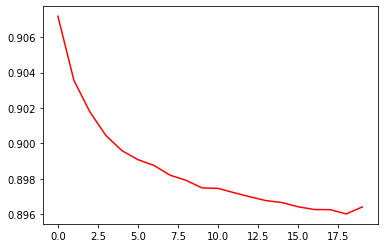

In [41]:
plt.plot(loss_list,color = 'r')

In [52]:
alphanet = alphanet.cpu()
pred_list = []
label_list = []
for _, (data, label) in enumerate(test_loader):
    data = Variable(data).float()
    pred = alphanet(data)
    pred_list.extend(pred.tolist())
    label_list.extend(label.tolist())

In [53]:
final = pd.DataFrame(pred_list)
final = pd.concat([target_list.reset_index(),final],axis=1)
final.rename(columns={0:Alpha_Name,'ticker': 'symbol'},inplace=True)
# final.set_index(["timestamp","symbol"],inplace=True)
final

,timestamp,symbol,target,AlphaNet_Original_Input_12.22_1d_return_normalized
0,2019-03-01 09:30:00,1,0.210976,-0.020684
1,2019-03-04 09:30:00,1,0.313131,-0.072253
2,2019-03-05 09:30:00,1,-0.643310,-0.060761
3,2019-03-06 09:30:00,1,-0.500139,-0.020684
4,2019-03-07 09:30:00,1,-1.180464,-0.087666
...,...,...,...,...
885421,2020-02-24 09:30:00,688399,1.771073,-0.020684
885422,2020-02-25 09:30:00,688399,1.498794,-0.020684
885423,2020-02-26 09:30:00,688399,-1.733627,-0.020684
885424,2020-02-27 09:30:00,688399,0.522789,-0.028828


In [35]:
# params = list(alphanet.named_parameters())
# len(params)
(name, param) = params[4]
print(name)
# print(param.grad)
# print('-------------------------------------------------')
# (name2, param2) = params[29]
# print(name2)
# print(param2.grad)
# print('----------------------------------------------------')
# (name1, param1) = params[30]
# print(name1)
# print(param1.grad)

out.weight


In [54]:
test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1]

'2019-03-01_2020-03-01.par'

In [55]:
final.to_parquet(output_path
                + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1])